<a href="https://colab.research.google.com/github/Ritviks21/Ai-image-detection-/blob/main/Defect_Detection_Data_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opencv-python numpy


In [2]:
import cv2
import numpy as np
import os
import random
import json

# --- Dataset Parameters ---
IMAGE_WIDTH = 512
IMAGE_HEIGHT = 512
NUM_IMAGES = 1000  # Number of synthetic images to generate
OUTPUT_DIR = "synthetic_defect_data" # Directory to save images and annotations

# --- Defect Parameters (you can adjust these later) ---
MAX_SCRATCHES_PER_IMAGE = 3
MAX_PARTICLES_PER_IMAGE = 5
MAX_BLOBS_PER_IMAGE = 2

SCRATCH_COLOR = (50, 50, 50)  # Dark gray
PARTICLE_COLOR = (200, 200, 200) # Light gray/white
BLOB_COLOR = (100, 100, 100) # Medium gray

# --- Ensure output directory exists ---
os.makedirs(os.path.join(OUTPUT_DIR, "images"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "annotations"), exist_ok=True)

print(f"Output directory '{OUTPUT_DIR}' created or already exists.")

Output directory 'synthetic_defect_data' created or already exists.


In [3]:
def create_base_wafer(width, height):
    """Creates a clean, uniform gray wafer image."""
    # Create a blank image with a medium gray color (like a silicon wafer)
    # OpenCV uses BGR format
    wafer = np.full((height, width, 3), 150, dtype=np.uint8) # A shade of gray
    return wafer

# Example usage (you can run this to see the base wafer)
# base_image = create_base_wafer(IMAGE_WIDTH, IMAGE_HEIGHT)
# cv2.imwrite("test_base_wafer.png", base_image) # Saves it to your Colab environment
# print("Test base wafer saved as 'test_base_wafer.png'")

In [4]:
def draw_scratch(image, scratch_color=(50, 50, 50)):
    """Draws a random scratch on the image and returns its bounding box."""
    img_h, img_w, _ = image.shape

    # Randomly determine start and end points for the scratch
    x1, y1 = random.randint(0, img_w), random.randint(0, img_h)
    x2, y2 = random.randint(0, img_w), random.randint(0, img_h)

    # Make scratches of varying thickness
    thickness = random.randint(1, 4)

    cv2.line(image, (x1, y1), (x2, y2), scratch_color, thickness)

    # Calculate bounding box for the scratch (approximate, lines are tricky)
    # For a line, a simple bounding box is min/max of x/y
    min_x = min(x1, x2)
    max_x = max(x1, x2)
    min_y = min(y1, y2)
    max_y = max(y1, y2)

    # Add a small buffer to the bounding box
    buffer = thickness * 2 # Account for thickness
    min_x = max(0, min_x - buffer)
    min_y = max(0, min_y - buffer)
    max_x = min(img_w, max_x + buffer)
    max_y = min(img_h, max_y + buffer)

    return {"class": "scratch", "bbox": [min_x, min_y, max_x, max_y]}


def draw_particle(image, particle_color=(200, 200, 200)):
    """Draws a random circular particle on the image and returns its bounding box."""
    img_h, img_w, _ = image.shape

    radius = random.randint(1, 5) # Particle size
    center_x = random.randint(radius, img_w - radius)
    center_y = random.randint(radius, img_h - radius)

    cv2.circle(image, (center_x, center_y), radius, particle_color, -1) # -1 fills the circle

    # Calculate bounding box
    min_x = max(0, center_x - radius)
    min_y = max(0, center_y - radius)
    max_x = min(img_w, center_x + radius)
    max_y = min(img_h, center_y + radius)

    return {"class": "particle", "bbox": [min_x, min_y, max_x, max_y]}

def draw_blob(image, blob_color=(100, 100, 100)):
    """Draws a random irregular blob on the image and returns its bounding box."""
    img_h, img_w, _ = image.shape

    num_vertices = random.randint(5, 10) # Number of points to define the blob
    max_radius = random.randint(10, 30)  # Max size of the blob

    # Starting point for the blob
    center_x = random.randint(max_radius, img_w - max_radius)
    center_y = random.randint(max_radius, img_h - max_radius)

    points = []
    for _ in range(num_vertices):
        angle = random.uniform(0, 2 * np.pi)
        radius = random.uniform(0, max_radius)
        x = int(center_x + radius * np.cos(angle))
        y = int(center_y + radius * np.sin(angle))
        points.append([x, y])

    # Convert to NumPy array for OpenCV
    points = np.array(points, np.int32).reshape((-1, 1, 2))

    cv2.fillPoly(image, [points], blob_color)

    # Calculate bounding box for the blob
    x_coords = [p[0][0] for p in points]
    y_coords = [p[0][1] for p in points]
    min_x = max(0, min(x_coords))
    min_y = max(0, min(y_coords))
    max_x = min(img_w, max(x_coords))
    max_y = min(img_h, max(y_coords))

    return {"class": "blob", "bbox": [min_x, min_y, max_x, max_y]}

In [5]:
# Create a dictionary to map class names to IDs (important for models like YOLO)
CLASS_NAMES = ["scratch", "particle", "blob"]
CLASS_TO_ID = {name: i for i, name in enumerate(CLASS_NAMES)}

print(f"Generating {NUM_IMAGES} synthetic images...")

all_annotations = [] # To store all annotations if we want a single annotation file later (e.g., COCO format)

for i in range(NUM_IMAGES):
    # 1. Create a base wafer image
    wafer_image = create_base_wafer(IMAGE_WIDTH, IMAGE_HEIGHT)

    current_image_annotations = [] # Annotations for the current image

    # 2. Add random scratches
    num_scratches = random.randint(0, MAX_SCRATCHES_PER_IMAGE)
    for _ in range(num_scratches):
        # Pass a copy of the image so subsequent drawings don't affect previous defect bounding box calculation
        annotation = draw_scratch(wafer_image, SCRATCH_COLOR)
        current_image_annotations.append(annotation)

    # 3. Add random particles
    num_particles = random.randint(0, MAX_PARTICLES_PER_IMAGE)
    for _ in range(num_particles):
        annotation = draw_particle(wafer_image, PARTICLE_COLOR)
        current_image_annotations.append(annotation)

    # 4. Add random blobs
    num_blobs = random.randint(0, MAX_BLOBS_PER_IMAGE)
    for _ in range(num_blobs):
        annotation = draw_blob(wafer_image, BLOB_COLOR)
        current_image_annotations.append(annotation)

    # 5. Save the image
    image_filename = os.path.join(OUTPUT_DIR, "images", f"wafer_{i:04d}.png")
    cv2.imwrite(image_filename, wafer_image)

    # 6. Save the annotations for this image
    annotation_filename = os.path.join(OUTPUT_DIR, "annotations", f"wafer_{i:04d}.json")

    # Convert class names to class IDs and ensure all numbers are standard Python ints
    formatted_annotations = []
    for ann in current_image_annotations:
        formatted_ann = ann.copy()
        formatted_ann["class_id"] = CLASS_TO_ID[ann["class"]]
        # Convert bounding box coordinates to standard Python integers
        formatted_ann["bbox"] = [int(coord) for coord in ann["bbox"]]
        formatted_annotations.append(formatted_ann)

    with open(annotation_filename, 'w') as f:
        json.dump(formatted_annotations, f, indent=4) # indent makes it readable

    if (i + 1) % 100 == 0:
        print(f"Generated {i + 1}/{NUM_IMAGES} images.")

print(f"\nFinished generating {NUM_IMAGES} synthetic images and annotations in '{OUTPUT_DIR}'.")# Create a dictionary to map class names to IDs (important for models like YOLO)
CLASS_NAMES = ["scratch", "particle", "blob"]
CLASS_TO_ID = {name: i for i, name in enumerate(CLASS_NAMES)}

print(f"Generating {NUM_IMAGES} synthetic images...")

all_annotations = [] # To store all annotations if we want a single annotation file later (e.g., COCO format)

for i in range(NUM_IMAGES):
    # 1. Create a base wafer image
    wafer_image = create_base_wafer(IMAGE_WIDTH, IMAGE_HEIGHT)

    current_image_annotations = [] # Annotations for the current image

    # 2. Add random scratches
    num_scratches = random.randint(0, MAX_SCRATCHES_PER_IMAGE)
    for _ in range(num_scratches):
        # Pass a copy of the image so subsequent drawings don't affect previous defect bounding box calculation
        annotation = draw_scratch(wafer_image, SCRATCH_COLOR)
        current_image_annotations.append(annotation)

    # 3. Add random particles
    num_particles = random.randint(0, MAX_PARTICLES_PER_IMAGE)
    for _ in range(num_particles):
        annotation = draw_particle(wafer_image, PARTICLE_COLOR)
        current_image_annotations.append(annotation)

    # 4. Add random blobs
    num_blobs = random.randint(0, MAX_BLOBS_PER_IMAGE)
    for _ in range(num_blobs):
        annotation = draw_blob(wafer_image, BLOB_COLOR)
        current_image_annotations.append(annotation)

    # 5. Save the image
    image_filename = os.path.join(OUTPUT_DIR, "images", f"wafer_{i:04d}.png")
    cv2.imwrite(image_filename, wafer_image)

    # 6. Save the annotations for this image
    annotation_filename = os.path.join(OUTPUT_DIR, "annotations", f"wafer_{i:04d}.json")

    # Convert class names to class IDs and ensure all numbers are standard Python ints
    formatted_annotations = []
    for ann in current_image_annotations:
        formatted_ann = ann.copy()
        formatted_ann["class_id"] = CLASS_TO_ID[ann["class"]]
        # Convert bounding box coordinates to standard Python integers
        formatted_ann["bbox"] = [int(coord) for coord in ann["bbox"]]
        formatted_annotations.append(formatted_ann)

    with open(annotation_filename, 'w') as f:
        json.dump(formatted_annotations, f, indent=4) # indent makes it readable

    if (i + 1) % 100 == 0:
        print(f"Generated {i + 1}/{NUM_IMAGES} images.")

print(f"\nFinished generating {NUM_IMAGES} synthetic images and annotations in '{OUTPUT_DIR}'.")

Generating 1000 synthetic images...
Generated 100/1000 images.
Generated 200/1000 images.
Generated 300/1000 images.
Generated 400/1000 images.
Generated 500/1000 images.
Generated 600/1000 images.
Generated 700/1000 images.
Generated 800/1000 images.
Generated 900/1000 images.
Generated 1000/1000 images.

Finished generating 1000 synthetic images and annotations in 'synthetic_defect_data'.
Generating 1000 synthetic images...
Generated 100/1000 images.
Generated 200/1000 images.
Generated 300/1000 images.
Generated 400/1000 images.
Generated 500/1000 images.
Generated 600/1000 images.
Generated 700/1000 images.
Generated 800/1000 images.
Generated 900/1000 images.
Generated 1000/1000 images.

Finished generating 1000 synthetic images and annotations in 'synthetic_defect_data'.


Found 1000 images. Displaying 5 random images...


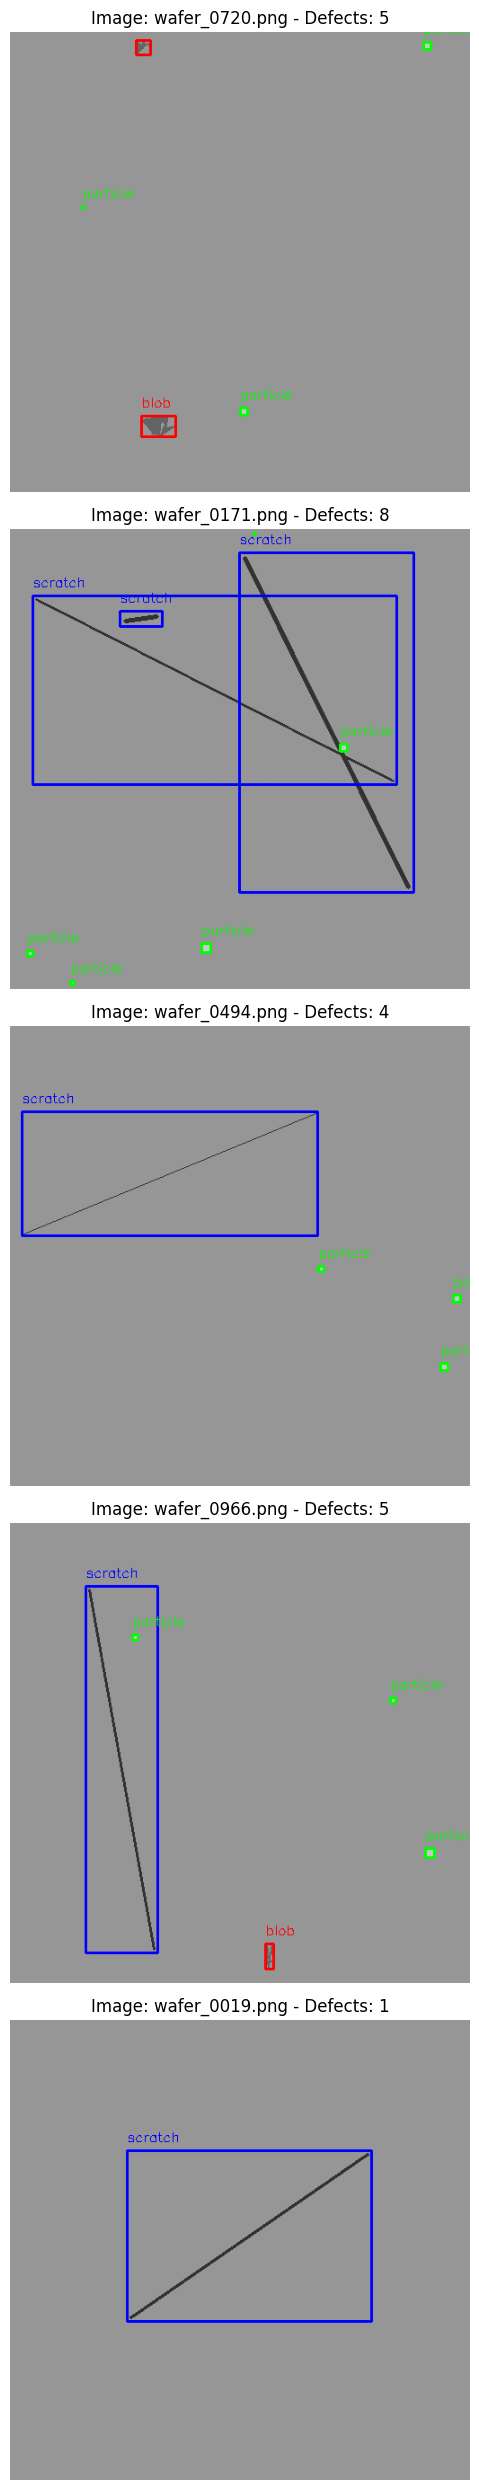

In [6]:
import cv2
import numpy as np
import os
import json
from matplotlib import pyplot as plt

# --- Configuration (match these to your generation script) ---
OUTPUT_DIR = "synthetic_defect_data"
NUM_IMAGES_TO_VIEW = 5 # How many random images you want to inspect

# Define colors for different defect types (BGR format)
# You can customize these if you want different colors for visualization
VIS_COLORS = {
    "scratch": (0, 0, 255),  # Red
    "particle": (0, 255, 0), # Green
    "blob": (255, 0, 0)      # Blue
}

# --- Function to draw bounding boxes ---
def draw_annotations_on_image(image, annotations, class_to_name_map):
    """Draws bounding boxes and labels on an image based on annotations."""
    display_image = image.copy()

    for ann in annotations:
        class_name = class_to_name_map[str(ann["class_id"])] # class_id might be int, ensure string for dict lookup if keys are strings
        bbox = ann["bbox"] # [x_min, y_min, x_max, y_max]

        x_min, y_min, x_max, y_max = bbox

        color = VIS_COLORS.get(class_name, (255, 255, 255)) # Default to white if not found

        # Draw rectangle
        cv2.rectangle(display_image, (x_min, y_min), (x_max, y_max), color, 2) # Thickness 2

        # Put label
        text = f"{class_name}"
        cv2.putText(display_image, text, (x_min, y_min - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1) # Font scale 0.5, thickness 1
    return display_image

# --- Prepare class name mapping for visualization ---
# Recreate CLASS_NAMES and CLASS_TO_ID from previous cell or define directly
CLASS_NAMES = ["scratch", "particle", "blob"]
CLASS_ID_TO_NAME = {str(i): name for i, name in enumerate(CLASS_NAMES)} # Ensure keys are strings

# --- Get a list of all generated images ---
image_files = [f for f in os.listdir(os.path.join(OUTPUT_DIR, "images")) if f.endswith('.png')]

if not image_files:
    print(f"No images found in {os.path.join(OUTPUT_DIR, 'images')}. Please ensure data generation completed.")
else:
    print(f"Found {len(image_files)} images. Displaying {min(NUM_IMAGES_TO_VIEW, len(image_files))} random images...")

    # Select random images to display
    random_image_files = random.sample(image_files, min(NUM_IMAGES_TO_VIEW, len(image_files)))

    plt.figure(figsize=(15, 5 * NUM_IMAGES_TO_VIEW)) # Adjust figure size dynamically

    for idx, img_file in enumerate(random_image_files):
        img_path = os.path.join(OUTPUT_DIR, "images", img_file)

        # Annotation file has the same base name, but .json extension
        annotation_file = img_file.replace(".png", ".json")
        annotation_path = os.path.join(OUTPUT_DIR, "annotations", annotation_file)

        # Load image
        img = cv2.imread(img_path)
        # OpenCV loads as BGR, matplotlib expects RGB, so convert
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Load annotations
        annotations = []
        if os.path.exists(annotation_path):
            with open(annotation_path, 'r') as f:
                annotations = json.load(f)
        else:
            print(f"Warning: Annotation file not found for {img_file}")
            continue

        # Draw annotations on the image
        img_with_boxes = draw_annotations_on_image(img_rgb, annotations, CLASS_ID_TO_NAME)

        # Display the image
        plt.subplot(NUM_IMAGES_TO_VIEW, 1, idx + 1)
        plt.imshow(img_with_boxes)
        plt.title(f"Image: {img_file} - Defects: {len(annotations)}")
        plt.axis('off') # Hide axes

    plt.tight_layout() # Adjust subplot params for a tight layout
    plt.show()


In [7]:
import os
import json
import cv2 # We need this to get image dimensions

# --- Configuration (match these to your generation script) ---
OUTPUT_DIR = "synthetic_defect_data"
IMAGE_WIDTH = 512
IMAGE_HEIGHT = 512

# Class mapping (must be consistent with your generation script)
CLASS_NAMES = ["scratch", "particle", "blob"]
CLASS_TO_ID = {name: i for i, name in enumerate(CLASS_NAMES)}

# Directory for YOLO format labels
YOLO_LABELS_DIR = os.path.join(OUTPUT_DIR, "labels")
os.makedirs(YOLO_LABELS_DIR, exist_ok=True)

print(f"Converting annotations to YOLO format in '{YOLO_LABELS_DIR}'...")

# Get a list of all generated annotation JSON files
json_annotation_files = [f for f in os.listdir(os.path.join(OUTPUT_DIR, "annotations")) if f.endswith('.json')]

if not json_annotation_files:
    print(f"No JSON annotation files found in {os.path.join(OUTPUT_DIR, 'annotations')}. Please ensure data generation completed.")
else:
    for json_file in json_annotation_files:
        json_path = os.path.join(OUTPUT_DIR, "annotations", json_file)

        # The corresponding YOLO label file will have the same base name but .txt extension
        yolo_label_filename = json_file.replace(".json", ".txt")
        yolo_label_path = os.path.join(YOLO_LABELS_DIR, yolo_label_filename)

        annotations = []
        with open(json_path, 'r') as f:
            annotations = json.load(f)

        yolo_lines = []
        for ann in annotations:
            class_id = ann["class_id"]
            bbox = ann["bbox"] # [x_min, y_min, x_max, y_max]

            x_min, y_min, x_max, y_max = bbox

            # Calculate width and height of the bounding box
            bbox_width = x_max - x_min
            bbox_height = y_max - y_min

            # Calculate center coordinates
            x_center = (x_min + x_max) / 2
            y_center = (y_min + y_max) / 2

            # Normalize coordinates by image width and height
            x_center_norm = x_center / IMAGE_WIDTH
            y_center_norm = y_center / IMAGE_HEIGHT
            bbox_width_norm = bbox_width / IMAGE_WIDTH
            bbox_height_norm = bbox_height / IMAGE_HEIGHT

            # Format the line for YOLO
            yolo_line = f"{class_id} {x_center_norm:.6f} {y_center_norm:.6f} {bbox_width_norm:.6f} {bbox_height_norm:.6f}"
            yolo_lines.append(yolo_line)

        # Write all YOLO lines for the current image to its .txt file
        with open(yolo_label_path, 'w') as f:
            f.write("\n".join(yolo_lines))

    print(f"\nFinished converting {len(json_annotation_files)} annotation files to YOLO format.")
    print(f"YOLO labels are saved in '{YOLO_LABELS_DIR}'.")

# You can quickly inspect one of the generated YOLO files
# First, list a few files to pick one:
# print("\nSample YOLO label files:")
# print(os.listdir(YOLO_LABELS_DIR)[:5])

# Then, open and print its content (replace with one of your actual filenames)
# sample_yolo_file = os.path.join(YOLO_LABELS_DIR, "wafer_0000.txt")
# if os.path.exists(sample_yolo_file):
#    print(f"\nContent of {sample_yolo_file}:")
#    with open(sample_yolo_file, 'r') as f:
#        print(f.read())

Converting annotations to YOLO format in 'synthetic_defect_data/labels'...

Finished converting 1000 annotation files to YOLO format.
YOLO labels are saved in 'synthetic_defect_data/labels'.


In [8]:
!pip install ultralytics

In [9]:
import os
import shutil
import random

# --- Configuration (match these to previous steps) ---
OUTPUT_DIR = "synthetic_defect_data"
YOLO_ROOT_DIR = "yolov8_dataset" # This will be the root for YOLOv8 structure

# Define paths for images and labels in the original structure
IMAGES_SOURCE_DIR = os.path.join(OUTPUT_DIR, "images")
LABELS_SOURCE_DIR = os.path.join(OUTPUT_DIR, "labels")

# Define paths for the new YOLOv8 structure
YOLO_IMAGES_TRAIN = os.path.join(YOLO_ROOT_DIR, "images", "train")
YOLO_IMAGES_VAL = os.path.join(YOLO_ROOT_DIR, "images", "val")
YOLO_LABELS_TRAIN = os.path.join(YOLO_ROOT_DIR, "labels", "train")
YOLO_LABELS_VAL = os.path.join(YOLO_ROOT_DIR, "labels", "val")

# Ensure all new directories exist
os.makedirs(YOLO_IMAGES_TRAIN, exist_ok=True)
os.makedirs(YOLO_IMAGES_VAL, exist_ok=True)
os.makedirs(YOLO_LABELS_TRAIN, exist_ok=True)
os.makedirs(YOLO_LABELS_VAL, exist_ok=True)

# Get all image filenames
all_image_files = [f for f in os.listdir(IMAGES_SOURCE_DIR) if f.endswith('.png')]
random.shuffle(all_image_files) # Shuffle to ensure random split

# Define split ratio
train_ratio = 0.8
train_split_index = int(len(all_image_files) * train_ratio)

train_files = all_image_files[:train_split_index]
val_files = all_image_files[train_split_index:]

print(f"Total images: {len(all_image_files)}")
print(f"Training images: {len(train_files)}")
print(f"Validation images: {len(val_files)}")

# --- Copy files to new YOLOv8 structure ---
print("Copying training images and labels...")
for img_file in train_files:
    label_file = img_file.replace(".png", ".txt")
    shutil.copy(os.path.join(IMAGES_SOURCE_DIR, img_file), YOLO_IMAGES_TRAIN)
    shutil.copy(os.path.join(LABELS_SOURCE_DIR, label_file), YOLO_LABELS_TRAIN)

print("Copying validation images and labels...")
for img_file in val_files:
    label_file = img_file.replace(".png", ".txt")
    shutil.copy(os.path.join(IMAGES_SOURCE_DIR, img_file), YOLO_IMAGES_VAL)
    shutil.copy(os.path.join(LABELS_SOURCE_DIR, label_file), YOLO_LABELS_VAL)

print("\nDataset organized for YOLOv8!")

# --- Create the dataset.yaml file ---
DATA_YAML_PATH = os.path.join(YOLO_ROOT_DIR, "dataset.yaml")

# Class names (must match the order of class_ids used in annotation generation)
CLASS_NAMES = ["scratch", "particle", "blob"]
nc = len(CLASS_NAMES) # Number of classes

data_yaml_content = f"""
path: ../{YOLO_ROOT_DIR} # Dataset root directory, relative to where YOLO will be run
train: images/train    # train images (relative to 'path')
val: images/val      # val images (relative to 'path')

nc: {nc}  # number of classes
names: {CLASS_NAMES} # class names
"""

with open(DATA_YAML_PATH, 'w') as f:
    f.write(data_yaml_content)

print(f"\nCreated dataset.yaml at '{DATA_YAML_PATH}':")
print(data_yaml_content)

Total images: 1000
Training images: 800
Validation images: 200
Copying training images and labels...
Copying validation images and labels...

Dataset organized for YOLOv8!

Created dataset.yaml at 'yolov8_dataset/dataset.yaml':

path: ../yolov8_dataset # Dataset root directory, relative to where YOLO will be run
train: images/train    # train images (relative to 'path')
val: images/val      # val images (relative to 'path')

nc: 3  # number of classes
names: ['scratch', 'particle', 'blob'] # class names



In [10]:
from ultralytics import YOLO
import os

# --- Configuration (match these to previous steps) ---
YOLO_ROOT_DIR = "yolov8_dataset" # This is where your dataset.yaml is located
DATA_YAML_PATH = os.path.join(YOLO_ROOT_DIR, "dataset.yaml")

# --- Model Training Parameters ---
# We'll use the 'nano' model for a start - it's fast and light
MODEL_NAME = 'yolov8n.pt' # 'n' for nano, 's' for small, 'm' for medium etc.
EPOCHS = 50 # Number of training epochs (iterations over the dataset)
BATCH_SIZE = 16 # Adjust this based on your Colab RAM. Start small, increase if no issues.
IMG_SIZE = 512 # Image size for training (must match your generated image size)
PROJECT_NAME = "defect_detection_project" # Name for the training run results
RUN_NAME = "yolov8n_synthetic_data" # Name for this specific training experiment

# Load a pre-trained YOLOv8n model
# This downloads the model weights if you don't have them
model = YOLO(MODEL_NAME)

print(f"Starting training with model: {MODEL_NAME}")
print(f"Dataset config: {DATA_YAML_PATH}")
print(f"Epochs: {EPOCHS}, Batch Size: {BATCH_SIZE}, Image Size: {IMG_SIZE}")

# Train the model
results = model.train(
    data=DATA_YAML_PATH,
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    name=RUN_NAME,
    project=PROJECT_NAME,
    seed=42 # For reproducibility
)

print("\nTraining completed!")


Starting training with model: yolov8n.pt
Dataset config: yolov8_dataset/dataset.yaml
Epochs: 50, Batch Size: 16, Image Size: 512
Ultralytics 8.3.160 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolov8_dataset/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_synthetic_data3, 

train: Scanning /content/yolov8_dataset/labels/train... 991 images, 16 backgrounds, 0 corrupt: 100%|██████████| 991/991 [00:00<00:00, 2302.34it/s]

train: New cache created: /content/yolov8_dataset/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 115.4±41.3 MB/s, size: 3.6 KB)


val: Scanning /content/yolov8_dataset/labels/val... 481 images, 6 backgrounds, 0 corrupt: 100%|██████████| 481/481 [00:00<00:00, 994.13it/s]

val: New cache created: /content/yolov8_dataset/labels/val.cache


Plotting labels to defect_detection_project/yolov8n_synthetic_data3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to defect_detection_project/yolov8n_synthetic_data3
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.29G      1.464      2.264      1.258         97        512: 100%|██████████| 62/62 [00:22<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.70it/s]


                   all        481       2391      0.897      0.185      0.421      0.271

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.61G      1.367       1.55      1.233        100        512: 100%|██████████| 62/62 [00:13<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.82it/s]

                   all        481       2391      0.704      0.719      0.754      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      1.61G      1.329      1.426      1.215         95        512: 100%|██████████| 62/62 [00:13<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.01it/s]

                   all        481       2391      0.769      0.714       0.76      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      1.63G      1.293      1.341      1.229         79        512: 100%|██████████| 62/62 [00:12<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.71it/s]

                   all        481       2391       0.83      0.729      0.809      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      1.65G      1.239      1.249      1.189        115        512: 100%|██████████| 62/62 [00:13<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.86it/s]

                   all        481       2391      0.861       0.76      0.833      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.65G       1.19      1.166      1.168         86        512: 100%|██████████| 62/62 [00:13<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.92it/s]

                   all        481       2391      0.873      0.771      0.837      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      1.65G      1.162      1.139      1.164         95        512: 100%|██████████| 62/62 [00:14<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.82it/s]

                   all        481       2391      0.876      0.774      0.849      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.65G      1.161      1.098      1.158         92        512: 100%|██████████| 62/62 [00:12<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.86it/s]

                   all        481       2391      0.902      0.759      0.852      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.65G      1.137      1.053      1.143        103        512: 100%|██████████| 62/62 [00:12<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.91it/s]

                   all        481       2391      0.903      0.788      0.874       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.65G      1.089       1.01       1.13         76        512: 100%|██████████| 62/62 [00:12<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.76it/s]

                   all        481       2391      0.917       0.81      0.882      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      1.66G      1.092       1.02      1.118         87        512: 100%|██████████| 62/62 [00:12<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.99it/s]

                   all        481       2391      0.933      0.789      0.885      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.67G      1.083     0.9965      1.121         96        512: 100%|██████████| 62/62 [00:12<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.07it/s]

                   all        481       2391      0.938      0.764      0.876      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      1.67G      1.042     0.9653      1.112         86        512: 100%|██████████| 62/62 [00:12<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.97it/s]

                   all        481       2391      0.917      0.749      0.856       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      1.68G      1.044     0.9504      1.106        100        512: 100%|██████████| 62/62 [00:12<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.78it/s]

                   all        481       2391      0.931      0.812      0.901      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50       1.7G      1.007     0.9223      1.093         92        512: 100%|██████████| 62/62 [00:12<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.97it/s]

                   all        481       2391       0.92      0.793      0.887      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50       1.7G     0.9935     0.9305      1.101        108        512: 100%|██████████| 62/62 [00:12<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.98it/s]

                   all        481       2391      0.924      0.799      0.909      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50       1.7G      1.008     0.9316        1.1         90        512: 100%|██████████| 62/62 [00:13<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.91it/s]

                   all        481       2391      0.934      0.797      0.905       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      1.72G     0.9565     0.8722       1.07         91        512: 100%|██████████| 62/62 [00:12<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.76it/s]

                   all        481       2391       0.93       0.79      0.897      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      1.72G     0.9549     0.8798      1.072         91        512: 100%|██████████| 62/62 [00:12<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.05it/s]

                   all        481       2391      0.914      0.801        0.9      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      1.72G     0.9348     0.8656      1.075         86        512: 100%|██████████| 62/62 [00:12<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.99it/s]

                   all        481       2391      0.928      0.793      0.894      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.72G     0.9431     0.8783      1.074        130        512: 100%|██████████| 62/62 [00:12<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.89it/s]

                   all        481       2391      0.953      0.799      0.909      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.72G     0.9205     0.8449      1.063        110        512: 100%|██████████| 62/62 [00:12<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.91it/s]

                   all        481       2391      0.927      0.821      0.914      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      1.72G     0.8939     0.8431      1.059        106        512: 100%|██████████| 62/62 [00:12<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.04it/s]

                   all        481       2391      0.933        0.8      0.907      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      1.72G     0.8914     0.8145      1.047        106        512: 100%|██████████| 62/62 [00:12<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.92it/s]

                   all        481       2391      0.931      0.825      0.913      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      1.72G     0.9114     0.8324      1.059         79        512: 100%|██████████| 62/62 [00:12<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.59it/s]

                   all        481       2391      0.947      0.804      0.911      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      1.72G     0.9124     0.8304      1.049        122        512: 100%|██████████| 62/62 [00:12<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.85it/s]

                   all        481       2391      0.923      0.816      0.903      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      1.72G     0.8869     0.8259      1.052        114        512: 100%|██████████| 62/62 [00:13<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.23it/s]

                   all        481       2391      0.942      0.811      0.915      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      1.72G      0.859     0.8078      1.032         96        512: 100%|██████████| 62/62 [00:12<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.77it/s]

                   all        481       2391      0.927      0.835      0.922      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      1.72G     0.8593     0.7937      1.037        126        512: 100%|██████████| 62/62 [00:12<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.87it/s]

                   all        481       2391      0.959       0.81       0.92      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      1.72G     0.8419     0.7821      1.038         89        512: 100%|██████████| 62/62 [00:12<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.03it/s]

                   all        481       2391      0.923      0.835      0.923      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      1.72G     0.8659     0.8165       1.05         80        512: 100%|██████████| 62/62 [00:13<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.02it/s]

                   all        481       2391      0.945       0.81      0.907      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      1.72G     0.8412     0.7818      1.028         93        512: 100%|██████████| 62/62 [00:12<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.36it/s]

                   all        481       2391      0.943      0.818      0.922      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      1.72G     0.8443     0.8001       1.04         90        512: 100%|██████████| 62/62 [00:12<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.01it/s]

                   all        481       2391      0.958      0.798      0.914      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      1.72G     0.8388     0.7871      1.033        109        512: 100%|██████████| 62/62 [00:12<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.94it/s]

                   all        481       2391       0.96      0.807      0.921      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      1.72G     0.8085     0.7693      1.017         85        512: 100%|██████████| 62/62 [00:13<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.83it/s]

                   all        481       2391      0.936      0.851       0.93      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      1.72G     0.7993     0.7638      1.015         54        512: 100%|██████████| 62/62 [00:12<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.12it/s]

                   all        481       2391      0.962      0.813      0.921       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      1.72G     0.8084     0.7591      1.015         92        512: 100%|██████████| 62/62 [00:12<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.64it/s]

                   all        481       2391      0.954      0.825       0.93      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      1.72G     0.8013     0.7584       1.02         93        512: 100%|██████████| 62/62 [00:12<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.67it/s]

                   all        481       2391      0.935      0.842      0.928      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      1.72G      0.784     0.7392      1.009        104        512: 100%|██████████| 62/62 [00:12<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.86it/s]

                   all        481       2391      0.944      0.816      0.923       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      1.72G     0.7825     0.7471      1.017         73        512: 100%|██████████| 62/62 [00:12<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.97it/s]

                   all        481       2391      0.959      0.822       0.93       0.77


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      1.72G     0.6365     0.5073     0.9104         62        512: 100%|██████████| 62/62 [00:13<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.06it/s]

                   all        481       2391      0.919      0.857      0.925      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      1.72G      0.622     0.4686     0.9045         59        512: 100%|██████████| 62/62 [00:11<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.16it/s]

                   all        481       2391      0.969      0.816      0.927      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      1.72G     0.6059     0.4554     0.9047         62        512: 100%|██████████| 62/62 [00:12<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.98it/s]

                   all        481       2391      0.915      0.867      0.929      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      1.72G     0.6047     0.4626      0.905         59        512: 100%|██████████| 62/62 [00:12<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.72it/s]

                   all        481       2391      0.955      0.824      0.928      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      1.72G     0.5971     0.4533     0.9049         69        512: 100%|██████████| 62/62 [00:12<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.89it/s]

                   all        481       2391      0.924      0.868      0.927      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      1.72G     0.6013     0.4491     0.9083         58        512: 100%|██████████| 62/62 [00:12<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.34it/s]

                   all        481       2391      0.924      0.871      0.932      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      1.72G     0.5745      0.435      0.895         67        512: 100%|██████████| 62/62 [00:12<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.99it/s]

                   all        481       2391       0.92      0.869      0.931      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      1.72G     0.5606     0.4276     0.8937         61        512: 100%|██████████| 62/62 [00:12<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.10it/s]

                   all        481       2391      0.913      0.874      0.934      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      1.72G     0.5496     0.4152       0.88         66        512: 100%|██████████| 62/62 [00:12<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.73it/s]

                   all        481       2391      0.918      0.868      0.934      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      1.72G     0.5642     0.4222     0.8861         48        512: 100%|██████████| 62/62 [00:12<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.71it/s]

                   all        481       2391      0.922      0.874      0.935      0.793



50 epochs completed in 0.236 hours.
Optimizer stripped from defect_detection_project/yolov8n_synthetic_data3/weights/last.pt, 6.2MB
Optimizer stripped from defect_detection_project/yolov8n_synthetic_data3/weights/best.pt, 6.2MB

Validating defect_detection_project/yolov8n_synthetic_data3/weights/best.pt...
Ultralytics 8.3.160 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.24it/s]


                   all        481       2391      0.923      0.874      0.935      0.793
               scratch        355        709      0.835      0.988      0.988      0.918
              particle        399       1200      0.969      0.645      0.825      0.604
                  blob        320        482      0.966       0.99      0.992      0.857
Speed: 0.2ms preprocess, 1.9ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to defect_detection_project/yolov8n_synthetic_data3

Training completed!


In [11]:
RUN_NAME = "yolov8n_synthetic_data" # Ensure this matches your actual run name


Successfully loaded model from: defect_detection_project/yolov8n_synthetic_data/weights/best.pt

Making predictions on 5 random images...

image 1/1 /content/synthetic_defect_data/images/wafer_0432.png: 512x512 4 scratchs, 1 particle, 6.2ms
Speed: 1.5ms preprocess, 6.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 /content/synthetic_defect_data/images/wafer_0819.png: 512x512 1 scratch, 6.4ms
Speed: 1.2ms preprocess, 6.4ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 /content/synthetic_defect_data/images/wafer_0800.png: 512x512 1 scratch, 2 particles, 2 blobs, 7.6ms
Speed: 1.3ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 /content/synthetic_defect_data/images/wafer_0690.png: 512x512 1 particle, 2 blobs, 6.5ms
Speed: 1.2ms preprocess, 6.5ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 /content/synthetic_defect_data/images/wafer_0188.png: 512x512 

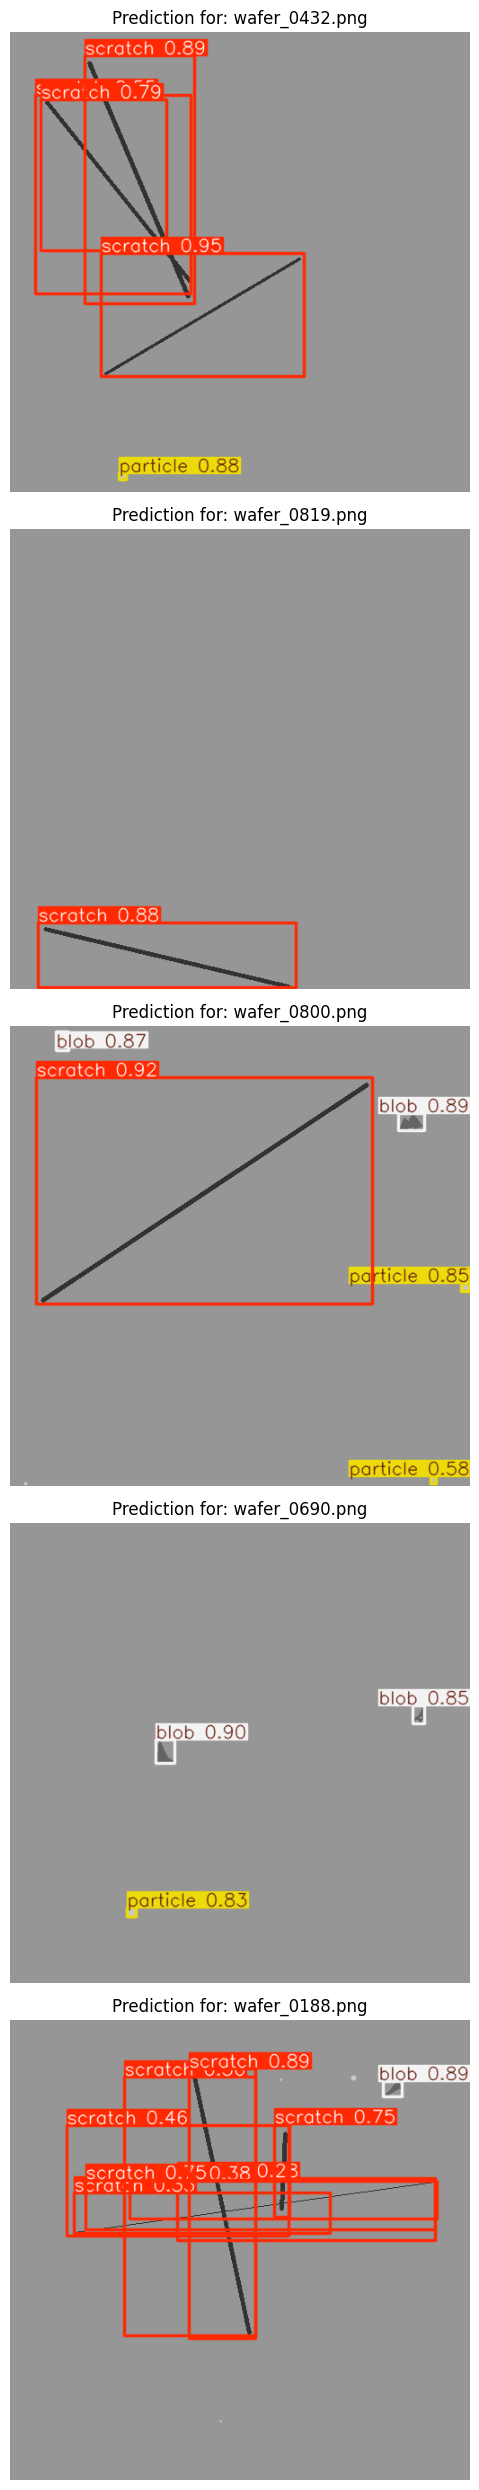


Prediction visualization complete. Check the displayed images above!


In [12]:
import os
import cv2
import matplotlib.pyplot as plt
import random
from ultralytics import YOLO # Moved this to the top of the cell for good practice

# --- Configuration ---
PROJECT_NAME = "defect_detection_project"
RUN_NAME = "yolov8n_synthetic_data" # This seems correct based on the structure implied by your output
                                   # If your run was actually 'yolov8n_synthetic_data2', update this.

# Corrected TRAINED_MODEL_PATH
# It seems your runs directory is INSIDE your project directory,
# not directly in /content/
TRAINED_MODEL_PATH = os.path.join(PROJECT_NAME, RUN_NAME, "weights", "best.pt")


# Original dataset paths to get some unseen images for prediction
OUTPUT_DIR = "synthetic_defect_data"
IMAGES_SOURCE_DIR = os.path.join(OUTPUT_DIR, "images")

# Load the trained model
try:
    model = YOLO(TRAINED_MODEL_PATH)
    print(f"Successfully loaded model from: {TRAINED_MODEL_PATH}")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Please ensure the TRAINED_MODEL_PATH is correct and the training run completed successfully.")
    print(f"Expected path: {os.path.abspath(TRAINED_MODEL_PATH)}") # This will now print the corrected path
    # If the model isn't found, you might need to adjust the RUN_NAME or check the folder structure

# --- Get a few random images from the dataset for prediction ---
# We'll pick from the original images directory (which includes both train and val)
all_image_files = [f for f in os.listdir(IMAGES_SOURCE_DIR) if f.endswith('.png')]
random_test_images = random.sample(all_image_files, min(5, len(all_image_files))) # Pick 5 random from ALL generated

print(f"\nMaking predictions on {len(random_test_images)} random images...")

plt.figure(figsize=(15, 5 * len(random_test_images)))

for i, img_file in enumerate(random_test_images):
    # Use the full path for prediction
    img_path = os.path.join(IMAGES_SOURCE_DIR, img_file)

    # Perform prediction
    # The 'conf' argument sets the confidence threshold for detections.
    # Only detections with confidence >= 0.25 will be shown by default.
    # 'iou' is the Intersection Over Union threshold for NMS (Non-Maximum Suppression)
    results = model.predict(source=img_path, save=False, show=False, conf=0.25, iou=0.7)

    # Process results (assuming single image prediction per call)
    for r in results:
        # Plot predictions on the image using ultralytics' plotting utility
        im_with_boxes = r.plot() # This returns an RGB numpy array

        plt.subplot(len(random_test_images), 1, i + 1)
        plt.imshow(im_with_boxes)
        plt.title(f"Prediction for: {img_file}")
        plt.axis('off')

plt.tight_layout()
plt.show()

print("\nPrediction visualization complete. Check the displayed images above!")

In [20]:
# No space before 's' in streamlit_app_code
streamlit_app_code = """
import streamlit as st
import cv2
# ... (all your streamlit app code here) ...
# No space before 's' in st.sidebar.info
st.sidebar.info("Developed for the Intel® AI Global Impact Festival.")
""" # No space before this closing triple quote

with open("app.py", "w") as f:
    f.write(streamlit_app_code)

print("Streamlit app.py created successfully!")
print("Next, run the app using: !streamlit run app.py --server.port 80")

Streamlit app.py created successfully!
Next, run the app using: !streamlit run app.py --server.port 80


In [21]:
# --- STEP 11: Run the Streamlit Application via Ngrok ---
print("Step 11: Setting up and running Streamlit application...")
# Install necessary libraries if not already present
!pip install pyngrok

from pyngrok import ngrok
import threading
import time
import os # Ensure os is imported here for os.system calls

# Kill any existing ngrok tunnels (useful if you run this cell multiple times)
# This command is often necessary in Colab to free up ports.
!kill $(lsof -t -i:8501) >/dev/null 2>&1 || true # Kill if on default 8501
!kill $(lsof -t -i:80) >/dev/null 2>&1 || true   # Kill if on our chosen port 80

# Authenticate ngrok (THIS IS CRUCIAL)
# Your authtoken: 2z8RgcnZROtxpOGEvJvTRknTg7T_6J11DQBiYn37rTz2Vp8B4
print("Authenticating ngrok...")
!ngrok authtoken 2z8RgcnZROtxpOGEvJvTRknTg7T_6J11DQBiYn37rTz2Vp8B4

# Define the Streamlit app path
APP_PATH = "app.py"

# Start Streamlit in a separate thread
def run_streamlit():
    os.system(f"streamlit run {APP_PATH} --server.port 80 --server.headless true --browser.gatherUsageStats false")

print("Starting Streamlit app in background...")
thread = threading.Thread(target=run_streamlit)
thread.daemon = True # Allows thread to exit when main program exits
thread.start()

# Wait for Streamlit to start up
time.sleep(15) # Give Streamlit a moment to start the server

print("Attempting to create ngrok tunnel...")
try:
    public_url = ngrok.connect(80, proto="http") # Port 80 as defined in streamlit run command
    print(f"Your Streamlit app is live at: {public_url}")
    print("Click the link above to open your application.")
except Exception as e:
    print(f"Error creating ngrok tunnel: {e}")
    print("If you still see an authentication error, please re-check your ngrok token on the dashboard.")
    print("\nStreamlit app might still be running locally in Colab, but not publicly accessible without ngrok.")

print("\nStreamlit app is running. This cell will remain active until manually stopped (click the stop square).")
print("Step 11: Streamlit application setup complete.")
print("-" * 50)

Step 11: Setting up and running Streamlit application...
Authenticating ngrok...
Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
Starting Streamlit app in background...
Attempting to create ngrok tunnel...
Your Streamlit app is live at: NgrokTunnel: "https://2720-35-247-151-232.ngrok-free.app" -> "http://localhost:80"
Click the link above to open your application.

Streamlit app is running. This cell will remain active until manually stopped (click the stop square).
Step 11: Streamlit application setup complete.
--------------------------------------------------


In [1]:
# --- STEP 10: Create Streamlit Application File ---
print("Step 10: Creating Streamlit application file (app.py)...")

# The entire content of this multi-line string MUST start at the first column
# No leading spaces before 'import streamlit', 'import cv2', etc., and especially not for the '"""'
streamlit_app_code = """
import streamlit as st
import cv2
import numpy as np
from ultralytics import YOLO
import os
from PIL import Image

# --- Configuration (match your training setup) ---
PROJECT_NAME = "defect_detection_project"
RUN_NAME = "yolov8n_synthetic_data" # Ensure this matches your actual run name
TRAINED_MODEL_PATH = os.path.join(PROJECT_NAME, RUN_NAME, "weights", "best.pt")

# Class names (must match the order used during training)
CLASS_NAMES = ["scratch", "particle", "blob"]
COLORS = {
    "scratch": (0, 0, 255),  # Red (BGR)
    "particle": (0, 255, 0), # Green (BGR)
    "blob": (255, 0, 0)      # Blue (BGR)
}

# --- Load the Model (cached to avoid reloading on every rerun) ---
@st.cache_resource
def load_model():
    try:
        model = YOLO(TRAINED_MODEL_PATH)
        st.success(f"Model loaded successfully from: {TRAINED_MODEL_PATH}")
        return model
    except Exception as e:
        st.error(f"Error loading model: {e}")
        st.warning(f"Please ensure the trained model path '{TRAINED_MODEL_PATH}' is correct and the training run completed successfully.")
        return None

# Load the model once
model = load_model()

# --- Streamlit UI ---
st.set_page_config(
    page_title="Wafer Defect Detector",
    page_icon="🔍",
    layout="wide",
    initial_sidebar_state="expanded"
)

st.title("🔬 Wafer Defect Detection")
st.markdown("Upload a wafer image to detect scratches, particles, and blobs.")

if model is None:
    st.stop() # Stop the app if model failed to load

# File Uploader
uploaded_file = st.file_uploader("Choose a wafer image...", type=["png", "jpg", "jpeg"])

if uploaded_file is not None:
    # Read the image
    file_bytes = np.asarray(bytearray(uploaded_file.read()), dtype=np.uint8)
    img_bgr = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR) # OpenCV reads as BGR

    if img_bgr is None:
        st.error("Could not load image. Please try another file.")
        st.stop()

    st.image(img_bgr, channels="BGR", caption="Uploaded Wafer Image", use_column_width=True)
    st.write("")
    st.subheader("Detecting Defects...")

    # Perform inference
    results = model.predict(source=img_bgr, save=False, show=False, conf=0.25, iou=0.7)

    # Process results and display
    for r in results:
        im_with_boxes = r.plot() # This returns an image with bounding boxes drawn, in RGB format

        # Display results
        st.image(im_with_boxes, channels="RGB", caption="Detected Defects", use_column_width=True)

        # Summarize detections
        detections_summary = {}
        if r.boxes: # Check if any boxes were detected
            for cls_id in r.boxes.cls.unique():
                count = (r.boxes.cls == cls_id).sum().item()
                class_name = CLASS_NAMES[int(cls_id)]
                detections_summary[class_name] = detections_summary.get(class_name, 0) + count

        st.subheader("Detection Summary:")
        if detections_summary:
            for defect_type, count in detections_summary.items():
                st.write(f"- **{defect_type.capitalize()}**: {count} detected")
        else:
            st.write("No defects detected in this image.")

st.sidebar.header("About This App")
st.sidebar.markdown(
    """
    This application uses a YOLOv8 object detection model, trained on
    synthetically generated wafer images, to identify common defects
    like scratches, particles, and blobs.

    **Model:** YOLOv8n
    **Classes:** Scratches, Particles, Blobs
    """
)
st.sidebar.info("Developed for the Intel® AI Global Impact Festival.")
""" # This closing triple quote MUST also be at the first column

with open("app.py", "w") as f:
    f.write(streamlit_app_code)

print("Step 10: Streamlit app.py created successfully!")
print("-" * 50)


# --- STEP 11: Run the Streamlit Application via Ngrok ---
print("Step 11: Setting up and running Streamlit application...")
# Install necessary libraries if not already present
!pip install pyngrok

from pyngrok import ngrok
import threading
import time
import os
import socket # Import socket for checking port status

# Kill any existing ngrok tunnels (useful if you run this cell multiple times)
!kill $(lsof -t -i:8501) >/dev/null 2>&1 || true
!kill $(lsof -t -i:80) >/dev/null 2>&1 || true


# Authenticate ngrok (THIS IS CRUCIAL)
# Your authtoken: 2z8RgcnZROtxpOGEvJvTRknTg7T_6J11DQBiYn37rTz2Vp8B4
print("Authenticating ngrok...")
!ngrok authtoken 2z8RgcnZROtxpOGEvJvTRknTg7T_6J11DQBiYn37rTz2Vp8B4

# Define the Streamlit app path
APP_PATH = "app.py"
STREAMLIT_PORT = 80 # The port Streamlit will run on

# Function to check if a port is in use
def is_port_in_use(port):
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        return s.connect_ex(('localhost', port)) == 0

# Start Streamlit in a separate thread
def run_streamlit():
    # Use -B to run in background (headless) and -s to specify the script
    # No --server.headless true as -B implicitly handles that
    os.system(f"streamlit run {APP_PATH} --server.port {STREAMLIT_PORT} --browser.gatherUsageStats false")

print(f"Starting Streamlit app in background on port {STREAMLIT_PORT}...")
thread = threading.Thread(target=run_streamlit)
thread.daemon = True
thread.start()

# Wait for Streamlit to start up
start_time = time.time()
timeout = 45 # Increased timeout to give Streamlit more time
print("Waiting for Streamlit to become available...")

while not is_port_in_use(STREAMLIT_PORT) and (time.time() - start_time) < timeout:
    time.sleep(2) # Check every 2 seconds

if not is_port_in_use(STREAMLIT_PORT):
    print(f"Streamlit did not start on port {STREAMLIT_PORT} within the timeout. Ngrok tunnel might fail.")
else:
    print(f"Streamlit detected listening on port {STREAMLIT_PORT}.")

print("Attempting to create ngrok tunnel...")
try:
    public_url = ngrok.connect(STREAMLIT_PORT, proto="http")
    print(f"Your Streamlit app is live at: {public_url}")
    print("Click the link above to open your application.")
except Exception as e:
    print(f"Error creating ngrok tunnel: {e}")
    print("If you still see an authentication error, please re-check your ngrok token on the dashboard.")
    print("If it's a connection refused error, Streamlit might not be running correctly on the specified port.")
    print("\nStreamlit app might still be running locally in Colab, but not publicly accessible without ngrok.")

print("\nStreamlit app is running. This cell will remain active until manually stopped (click the stop square).")
print("Step 11: Streamlit application setup complete.")
print("-" * 50)


IndentationError: unexpected indent (ipython-input-1-1750920944.py, line 100)